# Fitting Gravitationally Lensed Supernova Light Curves with GausSN

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

# Import the GausSN, kernel, meanfuncs, and lensingmodels packages
os.chdir('..')
from GausSN import gausSN, kernels, meanfuncs, lensingmodels
os.chdir('./ipynb')

# Use a stylesheet for stylish graphing!
plt.style.use('./stylesheet/GausSN.mplstyle')

## Define a few functions that will be useful for plotting and parameter optimization

In [2]:
# Specify a prior for dynesty's nested sampler
# See the dynesty documenation for more information about how to define a ptform
def ptform(u):
    prior = u
    prior[0] = u[0]
    prior[1] = (u[1] * 30) + 10
    prior[2] = (u[2] * 60)
    prior[3] = (u[3] * 0.9) + 0.1
    return(prior)
    
# Function for kernel and lensing parameter optimization
def fit_lensedSN(snid, data, show_plots=False):
    output_dict = {}
    
    # extract the number of images and wavelength filters/bands to fit
    im_ids = np.unique(data['image'])
    pb_ids = np.unique(data['band'])

    # Define a GP with a kernel and mean function
    meanfunc_params = [0]
    meanfunc = meanfuncs.UniformMean(meanfunc_params)
    kernel = kernels.ExpSquaredKernel([0.5, 20])
    gp = gausSN.GP(kernel, meanfunc)
        
    # Define a lensing model to use
    ## Here we use the most basic lensingmodels.LensingModel, which takes 2 parameters per band:
    ## a time delay and a magnification
    lm = lensingmodels.LensingModel([0, 0.5])
    sampler = gp.optimize_parameters(x = data['time'], y = data['flux'], yerr = data['fluxerr'],
                                     band = data['band'], image = data['image'],
                                     method='dynesty', ptform=ptform, sampler_kwargs = {'sample': 'unif'},
                                     lensing_model = lm, fix_mean_params=True)
    
    # If desired, plot the results of the parameter optimization
    if show_plots:
        plt.figure()
        param_names = ['A', 'tau']
        param_names = param_names + (['delta', 'beta'] * (len(im_ids)-1))
        fig, ax = dyplot.cornerplot(sampler.results, show_titles=True, labels=param_names)
        plt.show()
        plt.clf()
        plt.figure()
        fig, axes = dyplot.traceplot(sampler.results, show_titles=True, labels=param_names)
        fig.tight_layout()
        plt.show()
        plt.clf()
    
    # Return the sampler, so you can save the chains or any other information about the optimization, if desired
    return sampler

## Open the data and plot the raw light curves

In [3]:
# Specify location of data and file of interest
glSN_path = '../data/glSN_forGP_sims/'
files = [glSN_path+fn for fn in os.listdir(glSN_path) if fn.endswith('.csv')]
fn = files[10]

# Give a name (snid) to the object and open the data file
snid = fn.split('/')[-1].split('.')[0]
data = ascii.read(fn)
data.sort(['band', 'image', 'time'])

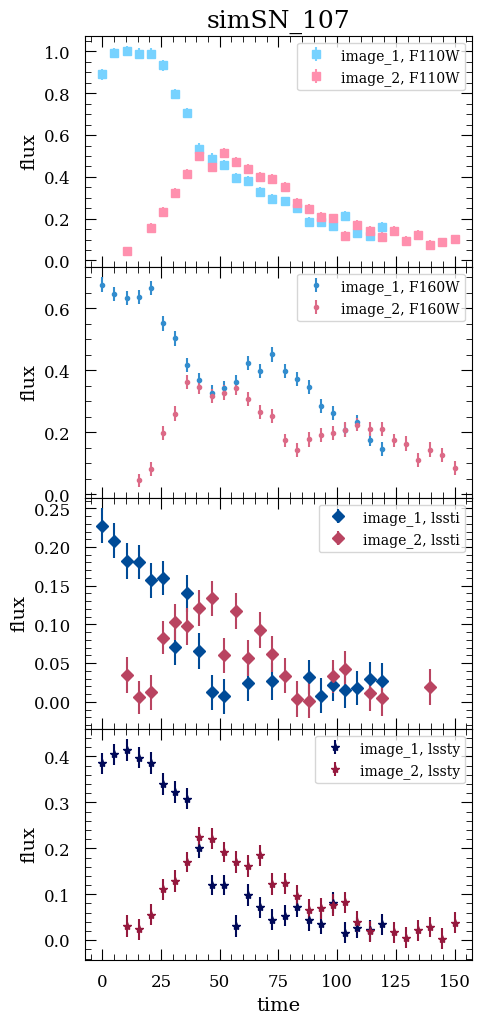

In [4]:
# Specify colors and markers for each image and band
colors = [['#77d2ff', '#338dce', '#004b97', '#000958'], ['#ff90ae', '#dc6a87', '#b94461', '#95193e']]
markers = ['s', '.', 'D', '*']

# We are going to plot a scaled version of the flux data, so that the maximum flux value of all the data is 1
# Here we compute the factor by which we'll scale the data
factor = np.max(data['flux']) - np.min(data['flux'])

# Create figure with subplots for each band
fig, ax = plt.subplots(len(np.unique(data['band'])), 1, figsize=(5,12), sharex=True)

# Loop over each band
for b, pb_id in enumerate(np.unique(data['band'])):
    band = data[data['band'] == pb_id]
    
    for m, im_id in enumerate(np.unique(data['image'])):
        image = band[band['image'] == im_id]
        
        # Plot the scaled flux data with error bars
        ax[b].errorbar(image['time'], image['flux']/factor, yerr=image['fluxerr']/factor,
                       ls='None', marker=markers[b], color=colors[m][b], label=f"{im_id}, {pb_id}")
        
        # Add legends, labels, and titles
        ax[b].legend()
        ax[b].set_ylabel('flux', fontsize=14)
        
ax[3].set_xlabel('time', fontsize=14)
ax[0].set_title(snid, fontsize=18)
plt.subplots_adjust(hspace=0)

## Fit a GP using Dynesty Nested Sampling for parameter optimization

5815it [08:19, 11.64it/s, +500 | bound: 17 | nc: 1 | ncall: 30810 | eff(%): 20.835 | loglstar:   -inf < 368.666 <    inf | logz: 357.761 +/-  0.147 | dlogz:  0.001 >  0.509]


<Figure size 640x480 with 0 Axes>

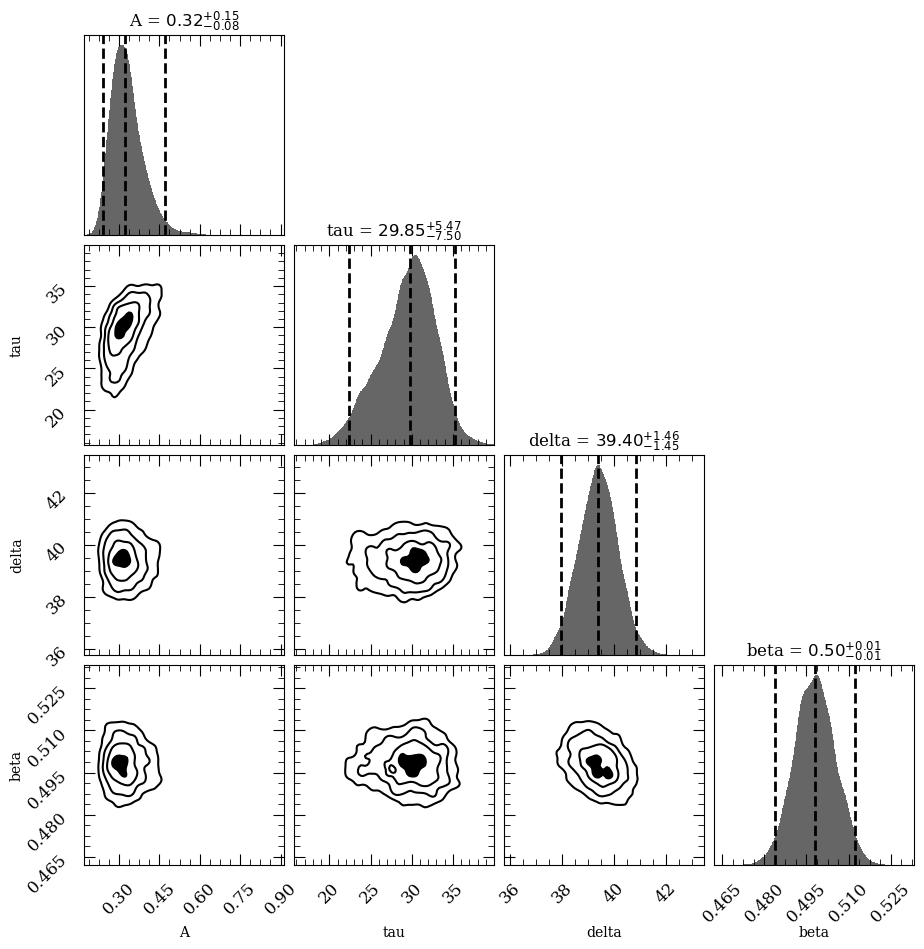

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

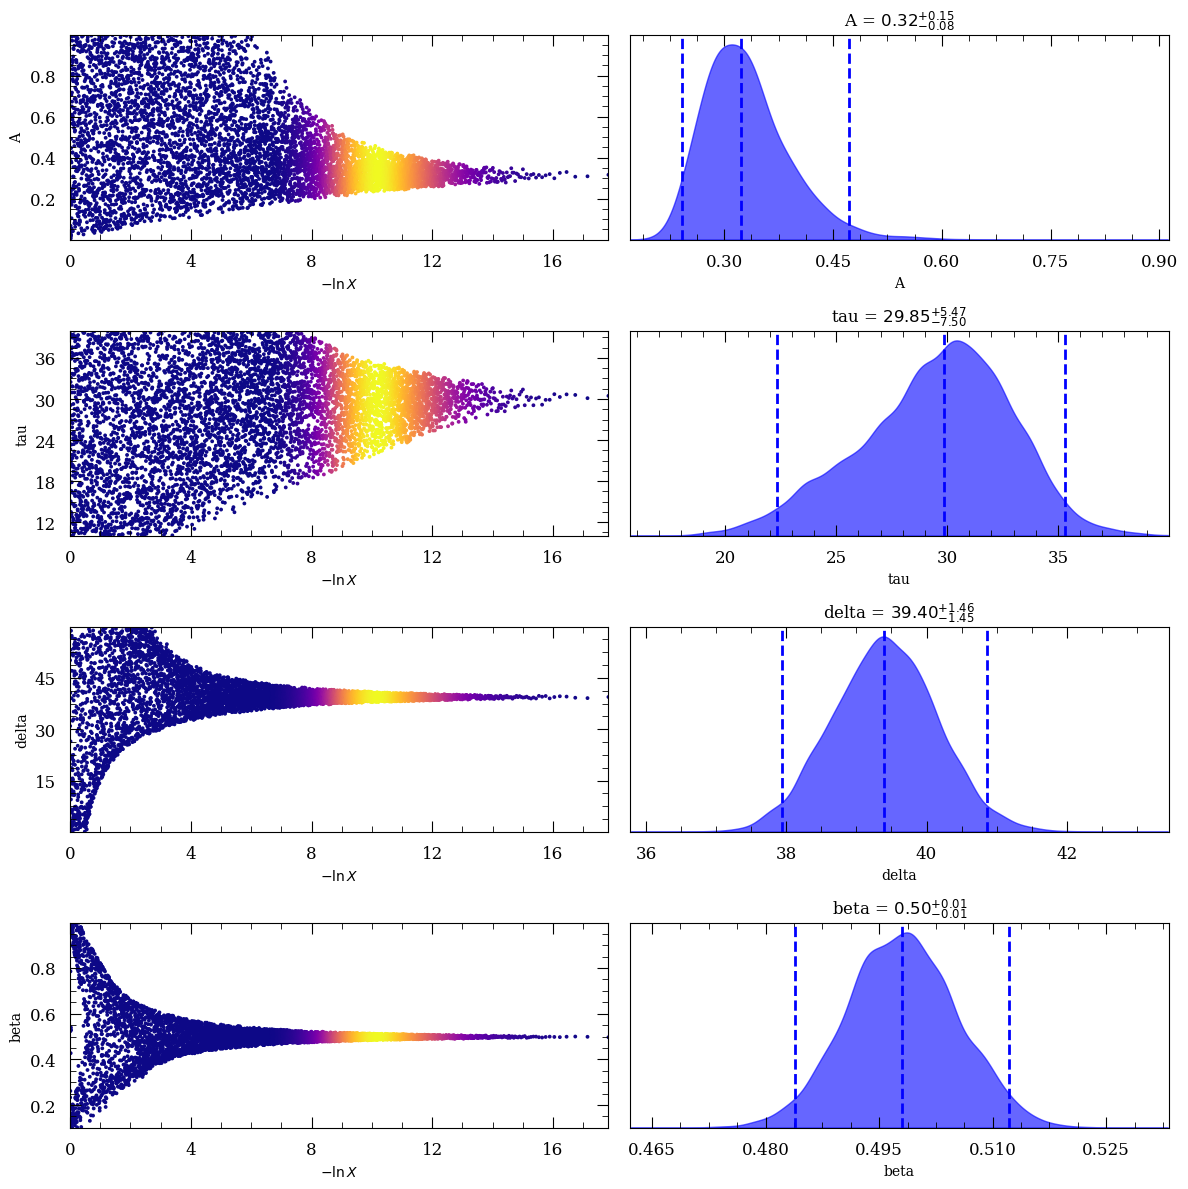

<Figure size 640x480 with 0 Axes>

In [5]:
sampler = fit_lensedSN(snid, data, show_plots=True)
    
# retrieve the fitted mean and variance of each parameter
mean, cov = dyfunc.mean_and_cov(sampler.results.samples, sampler.results.importance_weights())

## Replot the fitted light curve

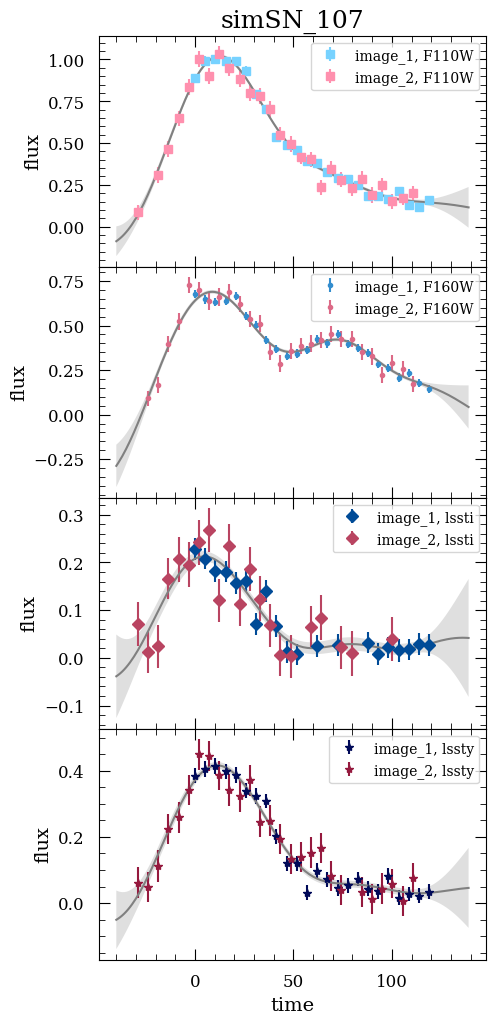

In [6]:
# set of times for plotting the fitted GP
times = np.arange(-40, 140, 1)

# redefine the gp (and therefore kernel and mean function) with the fitted kernel parameters
meanfunc = meanfuncs.UniformMean([0])
kernel = kernels.ExpSquaredKernel([mean[0], mean[1]])
gp = gausSN.GP(kernel, meanfunc)

fig, ax = plt.subplots(len(np.unique(data['band'])), 1, figsize=(5,12), sharex=True)

for b, pb_id in enumerate(np.unique(data['band'])):
    band = data[data['band'] == pb_id]
    
    stacked_x = []
    stacked_y = []
    stacked_yerr = []
    
    for m, im_id in enumerate(np.unique(data['image'])):
        image = band[band['image'] == im_id]
        
        if im_id == 'image_2':
            # shift image 2 in time by mean[2] (the time delay) and scale by mean[3] (the magnification)
            ax[b].errorbar(image['time']-mean[2], image['flux']/factor/mean[3], yerr=image['fluxerr']/factor/mean[3],
                           ls='None', marker=markers[b], color=colors[m][b], label=f"{im_id}, {pb_id}")
            
            # stack the time-shifted and magnified data for later use
            stacked_x = stacked_x + list(image['time']-mean[2])
            stacked_y = stacked_y + list(image['flux']/factor/mean[3])
            stacked_yerr = stacked_yerr + list(image['fluxerr']/factor/mean[3])
        
        else:
            # nothing changes about image 1!
            ax[b].errorbar(image['time'], image['flux']/factor, yerr=image['fluxerr']/factor,
                           ls='None', marker=markers[b], color=colors[m][b], label=f"{im_id}, {pb_id}")
            
            # stack the data for later use
            stacked_x = stacked_x + list(image['time'])
            stacked_y = stacked_y + list(image['flux']/factor)
            stacked_yerr = stacked_yerr + list(image['fluxerr']/factor)
            
        # Add legends and labels
        ax[b].legend()
        ax[b].set_ylabel('flux', fontsize=14)
    
    # use the GP with the best fit parameters to fit the curves at a more densly sampled set of times, times
    ## we use the time shifted and magnified (as appropriate) data to condition the GP
    exp, cov = gp.predict(times, np.array(stacked_x), np.array(stacked_y), np.array(stacked_yerr))
    
    # plot with a 1 sigma confidence region
    ax[b].plot(times, exp, color='gray')
    ax[b].fill_between(times, exp-np.sqrt(np.diag(cov)), exp + np.sqrt(np.diag(cov)), color='gray', alpha=0.25,
                       edgecolor='None')
        
# Add more labels
ax[3].set_xlabel('time', fontsize=14)
ax[0].set_title(snid, fontsize=18)
plt.subplots_adjust(hspace=0)